In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_path = os.path.join(os.getcwd(), "drive", "My Drive/mnist") # replace based on your Google drive organization
dataset_path = os.path.join(root_path, "data") # same here

Mounted at /content/drive


In [ ]:
pip uninstall mnist

In [ ]:
!pip install python-mnist
from mnist.loader import MNIST

In [ ]:
from scipy.special import softmax
from tqdm import tqdm
from matplotlib import pyplot
import os
import numpy
import scipy
import matplotlib
#import mnist
import pickle
import numpy as np
import copy
import time
%matplotlib inline
#mnist_data_directory = os.path.join(os.path.dirname(__file__), "data")
mnist_data_directory = dataset_path
# additional imports you may find useful for this assignment

# TODO add any additional imports and global variables


def load_MNIST_dataset():
 PICKLE_FILE = os.path.join(mnist_data_directory, "MNIST.pickle")
 print(PICKLE_FILE)
 try:
     dataset = pickle.load(open( PICKLE_FILE, 'rb'))
 except:
    # load the MNIST dataset
    mnist_data = MNIST(mnist_data_directory,
                             return_type="numpy", gz=True)
    Xs_tr, Lbls_tr = mnist_data.load_training()
    Xs_tr = Xs_tr.transpose() / 255.0
    Ys_tr = numpy.zeros((10, 60000))
    for i in range(60000):
        Ys_tr[Lbls_tr[i], i] = 1.0  # one-hot encode each label
    Xs_te, Lbls_te = mnist_data.load_testing()
    Xs_te = Xs_te.transpose() / 255.0
    Ys_te = numpy.zeros((10, 10000))
    for i in range(10000):
        Ys_te[Lbls_te[i], i] = 1.0  # one-hot encode each label

    dataset = (Xs_tr, Ys_tr, Xs_te, Ys_te)
    pickle.dump(dataset, open(PICKLE_FILE, 'wb'))
 return dataset



def multinomial_logreg_loss_i(x, y, gamma, W):
    Wx = W.dot(x)
    return numpy.sum(-numpy.log(softmax(Wx)) * y) + gamma / 2 * numpy.sum(W * W)


# compute the gradient of a single example of the multinomial logistic regression objective, with regularization
#
# x         training example   (d)
# y         training label     (c)
# gamma     L2 regularization constant
# W         parameters        (c * d)
#
# returns   the gradient of the model parameters
def multinomial_logreg_grad_i(x, y, gamma, W):
    Wx = W.dot(x)
    return numpy.expand_dims(softmax(Wx) - y, axis=1).dot(numpy.expand_dims(x, axis=0)) + gamma * W


# test that the function multinomial_logreg_grad_i is indeed the gradient of multinomial_logreg_loss_i
def test_gradient(Xs, Ys, gamma, W):
    v = numpy.random.randn(len(W), len(W[0]))
    eta = 1e-9

    # for part1 check
    #value1 = numpy.sum(v * (multinomial_logreg_grad_i(Xs[:, 0], Ys[:, 0], gamma, W)))
    #value2 = (multinomial_logreg_loss_i(Xs[:, 0], Ys[:, 0], gamma, W + v * eta) - multinomial_logreg_loss_i(Xs[:, 0], Ys[:, 0], gamma, W)) / eta

    # for part2 check
    value1 = numpy.sum(v * (multinomial_logreg_total_grad(Xs, Ys, gamma, W)))
    value2 = (multinomial_logreg_total_loss(Xs, Ys, gamma, W + v * eta) - multinomial_logreg_total_loss(Xs, Ys, gamma, W)) / eta
    relative_error = abs(value1 - value2) / abs(value1)
    #print(relative_error)
    return relative_error


# TODO students should implement this in Part 1
# compute the error of the classifier
#
# Xs        examples          (d * n)
# Ys        labels            (c * n)
# W         parameters        (c * d)
#
# returns   the model error as a percentage of incorrect labels
def multinomial_logreg_error(Xs, Ys, W):
    # TODO students should implement this
    h = softmax(W.dot(Xs))
    return numpy.sum(numpy.argmax(h, axis=0) != numpy.argmax(Ys, axis=0)) / len(Xs[0])


# compute the gradient of the multinomial logistic regression objective, with regularization
#
# Xs        training examples (d * n)
# Ys        training labels   (c * n)
# gamma     L2 regularization constant
# W         parameters        (c * d)
#
# returns   the gradient of the model parameters
def multinomial_logreg_total_grad(Xs, Ys, gamma, W):
    # a starter solution using an average of the example gradients
    # (d, n) = Xs.shape
    # acc = W * 0.0
    # for i in range(n):
    #     acc += multinomial_logreg_grad_i(Xs[:, i], Ys[:, i], gamma, W)
    # return acc / n

    # TODO students should implement this
    # vectorized numpy version
    d, n = Xs.shape
    grad = 1 / n * (softmax(W.dot(Xs), axis=0) - Ys).dot(Xs.T) + gamma * W
    return grad


# compute the cross-entropy loss of the classifier
#
# Xs        examples          (d * n)
# Ys        labels            (c * n)
# gamma     L2 regularization constant
# W         parameters        (c * d)
#
# returns   the model cross-entropy loss
def multinomial_logreg_total_loss(Xs, Ys, gamma, W):
    # a starter solution using an average of the example gradients
    # (d, n) = Xs.shape
    # acc = 0.0
    # for i in range(n):
    #     acc += multinomial_logreg_loss_i(Xs[:, i], Ys[:, i], gamma, W)
    # return acc / n

    # TODO students should implement this
    # vectorized numpy version
    d, n = Xs.shape
    loss = 1 / n * numpy.sum(-numpy.log(softmax(W.dot(Xs), axis=0)) * Ys) + gamma / 2 * numpy.sum(W * W)
    return loss


# run gradient descent on a multinomial logistic regression objective, with regularization
#
# Xs            training examples (d * n)
# Ys            training labels   (d * c)
# gamma         L2 regularization constant
# W0            the initial value of the parameters (c * d)
# alpha         step size/learning rate
# num_iters     number of iterations to run
# monitor_freq  how frequently to output the parameter vector
#
# returns       a list of models parameters, one every "monitor_freq" iterations
#               should return model parameters before iteration 0, iteration monitor_freq, iteration 2*monitor_freq, and again at the end
#               for a total of (num_iters/monitor_freq)+1 models, if num_iters is divisible by monitor_freq.
def gradient_descent(Xs, Ys, gamma, W0, alpha, num_iters, monitor_freq):
    param_list = []
    start_time = time.time()

    param_list.append(W0)
    for i in range(num_iters):
        if i % monitor_freq == monitor_freq - 1:
            param_list.append(copy.deepcopy(W0))
        grad = multinomial_logreg_total_grad(Xs, Ys, gamma, W0)
        W0 -= alpha * grad
    print("--- %s seconds ---" % (time.time() - start_time))
    return param_list


# estimate the error of the classifier
#
# Xs        examples          (d * n)
# Ys        labels            (c * n)
# gamma     L2 regularization constant
# W         parameters        (c * d)
# nsamples  number of samples to use for the estimation
#
# returns   the estimated model error when sampling with replacement
def estimate_multinomial_logreg_error(Xs, Ys, W, nsamples):
    d, n = Xs.shape
    rand = numpy.random.randint(0, n - nsamples)
    Xs = Xs[:, rand:rand + nsamples]
    Ys = Ys[:, rand:rand + nsamples]
    loss = 1 / nsamples * numpy.sum(-numpy.log(softmax(W.dot(Xs), axis=0)) * Ys) + gamma / 2 * numpy.sum(W * W)
    return loss



if __name__ == "__main__":
    (Xs_tr, Ys_tr, Xs_te, Ys_te) = load_MNIST_dataset()
    # TODO add code to produce figures
    gamma = 0.0001
    alpha = 1
    c, d = len(Ys_tr), len(Xs_tr)
    W = numpy.random.randn(c, d)

    # Part1
    #max_error = 0
    #for i in range(100):
        #max_error = max(test_gradient(Xs_tr, Ys_tr, gamma, W), max_error)
    #print(max_error)

    # Part2&3
    #para_list = gradient_descent(Xs_tr, Ys_tr, gamma, W, alpha, num_iters=10, monitor_freq=10)
    
    # Part4
    para_list = gradient_descent(Xs_tr, Ys_tr, gamma, W, alpha, num_iters=1000, monitor_freq=10)
    pickle.dump(para_list, open("para_list.pt", "wb"))
    para_list = pickle.load(open("para_list.pt", "rb"))
    train_error, test_error, train_loss, test_loss = [], [], [], []
    for i in range(len(para_list)):
        train_error.append(multinomial_logreg_error(Xs_tr, Ys_tr, para_list[i]))
        test_error.append(multinomial_logreg_error(Xs_te, Ys_te, para_list[i]))
        train_loss.append(multinomial_logreg_total_loss(Xs_tr, Ys_tr, gamma, para_list[i]))
        test_loss.append(multinomial_logreg_total_loss(Xs_te, Ys_te, gamma, para_list[i]))
    xaxis = numpy.linspace(0, 1000, 101)

    matplotlib.pyplot.plot(xaxis, train_error)
    matplotlib.pyplot.xlabel("Iterations")
    matplotlib.pyplot.ylabel("Train_error")

    #matplotlib.pyplot.savefig("train_error")
    matplotlib.pyplot.clf()

    matplotlib.pyplot.xlim(0, 1000)
    matplotlib.pyplot.plot(xaxis, test_error)
    matplotlib.pyplot.xlabel("Iterations")
    matplotlib.pyplot.ylabel("Test_error")
    #matplotlib.pyplot.savefig("test_error")
    matplotlib.pyplot.clf()

    matplotlib.pyplot.xlim(0, 1000)
    matplotlib.pyplot.plot(xaxis, train_loss)
    matplotlib.pyplot.xlabel("Iterations")
    matplotlib.pyplot.ylabel("Train_loss")
    #matplotlib.pyplot.savefig("train_loss")
    matplotlib.pyplot.clf()

    matplotlib.pyplot.xlim(0, 1000)
    matplotlib.pyplot.plot(xaxis, test_loss)
    matplotlib.pyplot.xlabel("Iterations")
    matplotlib.pyplot.ylabel("Test_loss")
    #matplotlib.pyplot.savefig("test_loss")
    matplotlib.pyplot.clf()


/content/drive/My Drive/mnist/data/MNIST.pickle
--- 259.84433579444885 seconds ---


<Figure size 432x288 with 0 Axes>

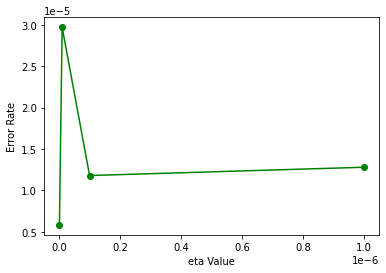

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
#折线图
x = [1e-6,1e-7,1e-8,1e-9]#点的横坐标

k2 = [1.278991308258607e-05,1.179e-05,2.97e-05,5.825124337264514e-06]#线2的纵坐标

plt.plot(x,k2,'o-',color = 'g',label="CNN-RLSTM")#o-:圆形
plt.xlabel("eta Value")#横坐标名字
plt.ylabel("Error Rate")#纵坐标名字

plt.show()

15.06
2.39
0.0499
0.06582
0.1994
0.2573


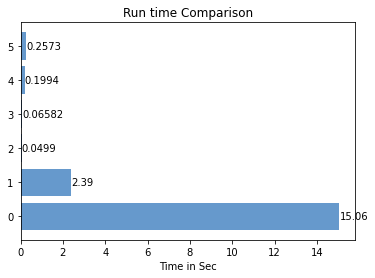

In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


waters = ('exact_train_error', 'exact_test_error', 'est100_train_error', 'est100_test_error', 'est1000_train_error','est1000_test_error')
buy_number = [15.06, 2.39, 0.0499, 0.06582, 0.1994,0.2573]

#train_error.append(multinomial_logreg_error(Xs_tr, Ys_tr, para_list[i]))#--- 15.063702821731567 seconds ---
        #test_error.append(multinomial_logreg_error(Xs_te, Ys_te, para_list[i]))#--- 2.393563985824585 seconds ---
        #train_loss.append(multinomial_logreg_total_loss(Xs_tr, Ys_tr, gamma, para_list[i]))#--- 16.729240894317627 seconds ---
        #test_loss.append(multinomial_logreg_total_loss(Xs_te, Ys_te, gamma, para_list[i]))#--- 2.5840861797332764 seconds ---
        #est100_train_error.append(estimate_multinomial_logreg_error(Xs_tr, Ys_tr, para_list[i], 100)) #--- 0.04983019828796387 seconds ---
        #est100_test_error.append(estimate_multinomial_logreg_error(Xs_te, Ys_te, para_list[i], 100))#--- 0.05584907531738281 seconds ---
        #est1000_train_error.append(estimate_multinomial_logreg_error(Xs_tr, Ys_tr, para_list[i], 1000))#--- 0.1774895191192627 seconds ---
        #est1000_test_error.append(estimate_multinomial_logreg_error(Xs_te, Ys_te, para_list[i], 1000))#--- 0.17852163314819336 seconds ---
        #est5000_train_error.append(estimate_multinomial_logreg_error(Xs_tr, Ys_tr, para_list[i], 5000))#--- 1.1200025081634521 seconds ---
        #est5000_test_error.append(estimate_multinomial_logreg_error(Xs_te, Ys_te, para_list[i], 5000))#--- 1.0452041625976562 seconds ---
#plt.barh(waters, buy_number)


fig, ax = plt.subplots()
b = ax.barh(range(len(waters)), buy_number, color='#6699CC',label='graph 1')
for rect in b:
    w = rect.get_width()
    print(w)
    ax.text(w, rect.get_y()+rect.get_height()/2, 
            w, ha='left', va='center')
plt.xlabel("Time in Sec")
plt.title('Run time Comparison')

plt.show()

In [ ]:
import torch
Xs_tr_tensor = torch.from_numpy(Xs_tr)
Ys_tr_tensor = torch.from_numpy(Ys_tr)
Xs_te_tensor = torch.from_numpy(Xs_te)
Ys_te_tensor = torch.from_numpy(Ys_te)
print(Xs_tr_tensor.size())
print(Ys_tr_tensor.size())
print(Xs_te_tensor.size())
print(Ys_te_tensor.size())

torch.Size([784, 60000])
torch.Size([10, 60000])
torch.Size([784, 10000])
torch.Size([10, 10000])
